In [2]:
# !pip install prophet

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 14.4 MB 8.3 MB/s eta 0:00:01 | 9.0 MB 8.3 MB/s eta 0:00:01
     |████████████████████████████████| 94 kB 3.2 MB/s  eta 0:00:01
     |████████████████████████████████| 1.0 MB 67.2 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid


In [4]:
def fetch_stock_data(symbol, start_date, end_date):
    """
    Fetches historical stock prices for a given symbol from start_date to end_date.
    Dates are exclusive
    
    :param symbol: str, stock symbol
    :param start_date: str, start date (YYYY-MM-DD format)
    :param end_date: str, end date (YYYY-MM-DD format)
    :return: DataFrame with historical stock data
    """
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    data.reset_index(inplace=True) 
    data['ds'] = data['Date'].dt.tz_localize(None)
    data.rename(columns={'Close': 'y'}, inplace=True)
    data = data[['ds', 'y']]
    data.drop_duplicates(subset=['ds'], inplace=True)
    return data


def model_param_evaluation(data, params):
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        changepoint_range=params['changepoint_range'],
        holidays_prior_scale=25,
        seasonality_prior_scale=10,
        weekly_seasonality=True,
        yearly_seasonality=True,
        daily_seasonality=False
    )
    model.add_country_holidays(country_name='US')
    model.fit(data)
    
    # Perform cross-validation
    df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
    df_p = performance_metrics(df_cv)
    return df_p['rmse'].mean()


def hyperparameter_tuning(data, param_grid):
    grid = ParameterGrid(param_grid)
    best_params = None
    best_rmse = float('inf')
    
    for params in grid:
        rmse = model_param_evaluation(data, params)
#         print(f"Tested params: {params}, RMSE: {rmse}")
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
    
    print(f"Best parameters: {best_params}, Best RMSE: {best_rmse}")
    return best_params



def train_prophet_model(data):
    param_grid = {
    'changepoint_prior_scale': [0.01, 0.015, 0.020, 0.025],
    'changepoint_range': [0.2, 0.4, 0.5, 0.8]

    }
    
    best_params = hyperparameter_tuning(data, param_grid)

    model = Prophet(
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        changepoint_range=best_params['changepoint_range'],
        holidays_prior_scale=25,
        seasonality_prior_scale=10,
        weekly_seasonality=True,
        yearly_seasonality=True,
        daily_seasonality=False
    )
    
    model.add_country_holidays(country_name='US')
    model.fit(data)
    return model

def train_prophet_original_model(data):

    model = Prophet(
        changepoint_prior_scale=0.02,
        changepoint_range=0.95,
        holidays_prior_scale=25,
        seasonality_prior_scale=10,
        weekly_seasonality=True,
        yearly_seasonality=True,
        daily_seasonality=False
    )
    
    model.add_country_holidays(country_name='US')
    model.fit(data)
    return model    
    

def gen_stock_forecast(symbol, start_date, end_date, num_days):
    # Fetch data
    data = fetch_stock_data(symbol, start_date, end_date)

    # Train Prophet model
    model = train_prophet_model(data)

    # Make future dataframe for prediction
    future = model.make_future_dataframe(periods=num_days)

    # Predict future values
    forecast = model.predict(future)
    
    prev_avg = data.tail(num_days)['y'].mean()
    next_avg = forecast['yhat'].mean()
    
    trend = (prev_avg + next_avg) / 2
#     model.plot(forecast.to_numpy())

    return model, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(num_days), forecast, trend

def gen_stock_forecast_original(symbol, start_date, end_date, num_days):
    # Fetch data
    data = fetch_stock_data(symbol, start_date, end_date)

    # Train Prophet model
    model = train_prophet_original_model(data)

    # Make future dataframe for prediction
    future = model.make_future_dataframe(periods=num_days)

    # Predict future values
    forecast = model.predict(future)
    
    prev_avg = data.tail(num_days)['y'].mean()
    next_avg = forecast['yhat'].mean()
    
    trend = (prev_avg + next_avg) / 2
#     model.plot(forecast.to_numpy())

    return model, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(num_days), forecast, trend


    

00:38:15 - cmdstanpy - INFO - Chain [1] start processing
00:38:16 - cmdstanpy - INFO - Chain [1] done processing


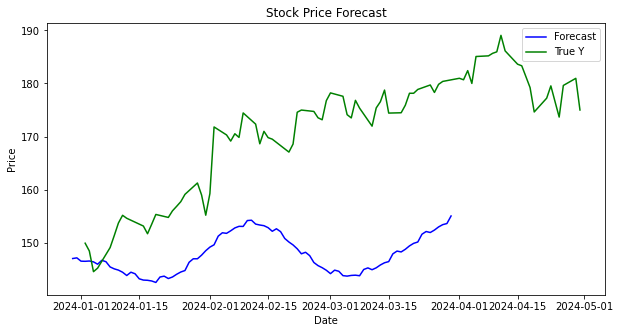

In [5]:
sym = 'AMZN'
start = '2020-01-01'
end = '2024-01-01'
num_days = 92

model, amzn_fc, amzn_all, amzn_trend = gen_stock_forecast_original(sym, start, end, num_days)
amzn_true = fetch_stock_data('AMZN', '2024-01-01', '2024-05-01')

plt.figure(figsize=(10, 5))


plt.plot(np.array(amzn_fc['ds']), np.array(amzn_fc['yhat']), label='Forecast', color='blue')
plt.plot(np.array(amzn_true['ds']), np.array(amzn_true['y']), label='True Y', color='green')

plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [14]:
sym = 'AMZN'
start = '2020-01-01'
end = '2024-01-01'
num_days = 100

model, amzn_fc, amzn_all, amzn_trend = gen_stock_forecast(sym, start, end, num_days)
amzn_true = fetch_stock_data('AMZN', '2024-01-01', '2024-05-01')

plt.figure(figsize=(10, 5))


plt.plot(np.array(amzn_fc['ds']), np.array(amzn_fc['yhat']), label='Forecast', color='blue')
plt.plot(np.array(amzn_true['ds']), np.array(amzn_true['y']), label='True Y', color='green')

plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

00:45:21 - cmdstanpy - INFO - Chain [1] start processing
00:45:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

00:45:21 - cmdstanpy - INFO - Chain [1] start processing
00:45:21 - cmdstanpy - INFO - Chain [1] done processing
00:45:22 - cmdstanpy - INFO - Chain [1] start processing
00:45:22 - cmdstanpy - INFO - Chain [1] done processing
00:45:23 - cmdstanpy - INFO - Chain [1] start processing
00:45:23 - cmdstanpy - INFO - Chain [1] done processing
00:45:24 - cmdstanpy - INFO - Chain [1] start processing
00:45:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

00:45:24 - cmdstanpy - INFO - Chain [1] start processing
00:45:24 - cmdstanpy - INFO - Chain [1] done processing
00:45:25 - cmdstanpy - INFO - Chain [1] start processing
00:45:25 - cmdstanpy - INFO - Chain [1] done processing


KeyboardInterrupt: 

16:32:06 - cmdstanpy - INFO - Chain [1] start processing
16:32:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:32:07 - cmdstanpy - INFO - Chain [1] start processing
16:32:07 - cmdstanpy - INFO - Chain [1] done processing
16:32:08 - cmdstanpy - INFO - Chain [1] start processing
16:32:08 - cmdstanpy - INFO - Chain [1] done processing
16:32:08 - cmdstanpy - INFO - Chain [1] start processing
16:32:09 - cmdstanpy - INFO - Chain [1] done processing
16:32:10 - cmdstanpy - INFO - Chain [1] start processing
16:32:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:32:10 - cmdstanpy - INFO - Chain [1] start processing
16:32:10 - cmdstanpy - INFO - Chain [1] done processing
16:32:11 - cmdstanpy - INFO - Chain [1] start processing
16:32:11 - cmdstanpy - INFO - Chain [1] done processing
16:32:12 - cmdstanpy - INFO - Chain [1] start processing
16:32:12 - cmdstanpy - INFO - Chain [1] done processing
16:32:13 - cmdstanpy - INFO - Chain [1] start processing
16:32:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:32:13 - cmdstanpy - INFO - Chain [1] start processing
16:32:13 - cmdstanpy - INFO - Chain [1] done processing
16:32:14 - cmdstanpy - INFO - Chain [1] start processing
16:32:14 - cmdstanpy - INFO - Chain [1] done processing
16:32:15 - cmdstanpy - INFO - Chain [1] start processing
16:32:15 - cmdstanpy - INFO - Chain [1] done processing
16:32:16 - cmdstanpy - INFO - Chain [1] start processing
16:32:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:32:17 - cmdstanpy - INFO - Chain [1] start processing
16:32:17 - cmdstanpy - INFO - Chain [1] done processing
16:32:17 - cmdstanpy - INFO - Chain [1] start processing
16:32:17 - cmdstanpy - INFO - Chain [1] done processing
16:32:18 - cmdstanpy - INFO - Chain [1] start processing
16:32:18 - cmdstanpy - INFO - Chain [1] done processing
16:32:19 - cmdstanpy - INFO - Chain [1] start processing
16:32:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:32:20 - cmdstanpy - INFO - Chain [1] start processing
16:32:20 - cmdstanpy - INFO - Chain [1] done processing
16:32:21 - cmdstanpy - INFO - Chain [1] start processing
16:32:21 - cmdstanpy - INFO - Chain [1] done processing
16:32:21 - cmdstanpy - INFO - Chain [1] start processing
16:32:22 - cmdstanpy - INFO - Chain [1] done processing
16:32:22 - cmdstanpy - INFO - Chain [1] start processing
16:32:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:32:23 - cmdstanpy - INFO - Chain [1] start processing
16:32:23 - cmdstanpy - INFO - Chain [1] done processing
16:32:24 - cmdstanpy - INFO - Chain [1] start processing
16:32:24 - cmdstanpy - INFO - Chain [1] done processing
16:32:25 - cmdstanpy - INFO - Chain [1] start processing
16:32:25 - cmdstanpy - INFO - Chain [1] done processing
16:32:26 - cmdstanpy - INFO - Chain [1] start processing
16:32:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:32:26 - cmdstanpy - INFO - Chain [1] start processing
16:32:26 - cmdstanpy - INFO - Chain [1] done processing
16:32:27 - cmdstanpy - INFO - Chain [1] start processing
16:32:27 - cmdstanpy - INFO - Chain [1] done processing
16:32:28 - cmdstanpy - INFO - Chain [1] start processing
16:32:28 - cmdstanpy - INFO - Chain [1] done processing
16:32:29 - cmdstanpy - INFO - Chain [1] start processing
16:32:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:32:29 - cmdstanpy - INFO - Chain [1] start processing
16:32:29 - cmdstanpy - INFO - Chain [1] done processing
16:32:30 - cmdstanpy - INFO - Chain [1] start processing
16:32:30 - cmdstanpy - INFO - Chain [1] done processing
16:32:31 - cmdstanpy - INFO - Chain [1] start processing
16:32:31 - cmdstanpy - INFO - Chain [1] done processing
16:32:32 - cmdstanpy - INFO - Chain [1] start processing
16:32:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:32:33 - cmdstanpy - INFO - Chain [1] start processing
16:32:33 - cmdstanpy - INFO - Chain [1] done processing
16:32:34 - cmdstanpy - INFO - Chain [1] start processing
16:32:34 - cmdstanpy - INFO - Chain [1] done processing
16:32:35 - cmdstanpy - INFO - Chain [1] start processing
16:32:35 - cmdstanpy - INFO - Chain [1] done processing
16:32:36 - cmdstanpy - INFO - Chain [1] start processing
16:32:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:32:36 - cmdstanpy - INFO - Chain [1] start processing
16:32:36 - cmdstanpy - INFO - Chain [1] done processing
16:32:37 - cmdstanpy - INFO - Chain [1] start processing
16:32:37 - cmdstanpy - INFO - Chain [1] done processing
16:32:38 - cmdstanpy - INFO - Chain [1] start processing
16:32:38 - cmdstanpy - INFO - Chain [1] done processing
16:32:39 - cmdstanpy - INFO - Chain [1] start processing
16:32:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:32:39 - cmdstanpy - INFO - Chain [1] start processing
16:32:39 - cmdstanpy - INFO - Chain [1] done processing
16:32:40 - cmdstanpy - INFO - Chain [1] start processing
16:32:40 - cmdstanpy - INFO - Chain [1] done processing
16:32:41 - cmdstanpy - INFO - Chain [1] start processing
16:32:41 - cmdstanpy - INFO - Chain [1] done processing
16:32:42 - cmdstanpy - INFO - Chain [1] start processing
16:32:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:32:43 - cmdstanpy - INFO - Chain [1] start processing
16:32:43 - cmdstanpy - INFO - Chain [1] done processing
16:32:43 - cmdstanpy - INFO - Chain [1] start processing
16:32:43 - cmdstanpy - INFO - Chain [1] done processing
16:32:44 - cmdstanpy - INFO - Chain [1] start processing
16:32:44 - cmdstanpy - INFO - Chain [1] done processing
16:32:45 - cmdstanpy - INFO - Chain [1] start processing
16:32:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:32:46 - cmdstanpy - INFO - Chain [1] start processing
16:32:46 - cmdstanpy - INFO - Chain [1] done processing
16:32:47 - cmdstanpy - INFO - Chain [1] start processing
16:32:47 - cmdstanpy - INFO - Chain [1] done processing
16:32:48 - cmdstanpy - INFO - Chain [1] start processing
16:32:48 - cmdstanpy - INFO - Chain [1] done processing
16:32:49 - cmdstanpy - INFO - Chain [1] start processing
16:32:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:32:49 - cmdstanpy - INFO - Chain [1] start processing
16:32:49 - cmdstanpy - INFO - Chain [1] done processing
16:32:50 - cmdstanpy - INFO - Chain [1] start processing
16:32:50 - cmdstanpy - INFO - Chain [1] done processing
16:32:51 - cmdstanpy - INFO - Chain [1] start processing
16:32:51 - cmdstanpy - INFO - Chain [1] done processing
16:32:52 - cmdstanpy - INFO - Chain [1] start processing
16:32:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:32:53 - cmdstanpy - INFO - Chain [1] start processing
16:32:53 - cmdstanpy - INFO - Chain [1] done processing
16:32:53 - cmdstanpy - INFO - Chain [1] start processing
16:32:54 - cmdstanpy - INFO - Chain [1] done processing
16:32:54 - cmdstanpy - INFO - Chain [1] start processing
16:32:54 - cmdstanpy - INFO - Chain [1] done processing
16:32:55 - cmdstanpy - INFO - Chain [1] start processing
16:32:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:32:56 - cmdstanpy - INFO - Chain [1] start processing
16:32:56 - cmdstanpy - INFO - Chain [1] done processing
16:32:57 - cmdstanpy - INFO - Chain [1] start processing
16:32:57 - cmdstanpy - INFO - Chain [1] done processing
16:32:58 - cmdstanpy - INFO - Chain [1] start processing
16:32:58 - cmdstanpy - INFO - Chain [1] done processing
16:32:59 - cmdstanpy - INFO - Chain [1] start processing


Best parameters: {'changepoint_prior_scale': 0.025, 'changepoint_range': 0.4}, Best RMSE: 28.83535738752637


16:32:59 - cmdstanpy - INFO - Chain [1] done processing


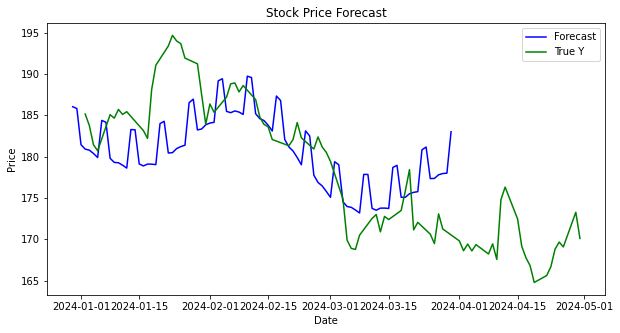

In [6]:
sym = 'AAPL'
start = '2020-01-01'
end = '2024-01-01'
num_days = 92

model, aapl_fc, aapl_all, aapl_trend = gen_stock_forecast(sym, start, end, num_days)
aapl_true = fetch_stock_data('AAPL', '2024-01-01', '2024-05-01')

plt.figure(figsize=(10, 5))
plt.plot(np.array(aapl_fc['ds']), np.array(aapl_fc['yhat']), label='Forecast', color='blue')
plt.plot(np.array(aapl_true['ds']), np.array(aapl_true['y']), label='True Y', color='green')

plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

16:33:01 - cmdstanpy - INFO - Chain [1] start processing
16:33:01 - cmdstanpy - INFO - Chain [1] done processing


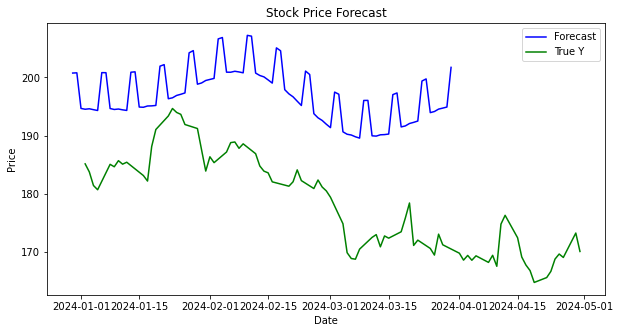

In [7]:
sym = 'AAPL'
start = '2020-01-01'
end = '2024-01-01'
num_days = 92

model, aapl_fc, aapl_all, aapl_trend = gen_stock_forecast_original(sym, start, end, num_days)
aapl_true = fetch_stock_data('AAPL', '2024-01-01', '2024-05-01')

plt.figure(figsize=(10, 5))
plt.plot(np.array(aapl_fc['ds']), np.array(aapl_fc['yhat']), label='Forecast', color='blue')
plt.plot(np.array(aapl_true['ds']), np.array(aapl_true['y']), label='True Y', color='green')

plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [7]:
amzn_trend

135.61476783990395

In [10]:
# aapl_trend
aapl_fc

NameError: name 'aapl_fc' is not defined

In [10]:
def main_forecast(ticker, start_date, end_date, days_to_predict):
    model, fc, fc_all, fc_trend = gen_stock_forecast(ticker, start_date, end_date, days_to_predict)
    
    pred_date = datetime.strptime(end_date, '%Y-%m-%d') + timedelta(days=92)
    pred_date = pred_date.strftime('%Y-%m-%d')
    
    cl = (fc['yhat_upper'] - fc['yhat_lower']).mean()
    
    
#     fc_true = fetch_stock_data(ticker, end_date, pred_date)

    
#     plt.figure(figsize=(10, 5))
#     plt.plot(np.array(fc['ds']), np.array(fc['yhat']), label='Forecast', color='blue')
#     plt.plot(np.array(fc_true['ds']), np.array(fc_true['y']), label='True Y', color='green')

#     plt.title(f'{ticker} Price Forecast')
#     plt.xlabel('Date')
#     plt.ylabel('Price')
#     plt.legend()
#     plt.show()
    
    # smaller confidence level range means greater confidence
    return fc_trend, cl

In [11]:
def stock_options_weights(tick1, tick2, tick3, start_date, end_date, days_to_predict):
    def calculate_weights(x1, x2, x3):
        # Calculate the inverse of each value
        inverse1 = 1 / (x1 + 1e-10)  # Adding a small epsilon to avoid division by zero
        inverse2 = 1 / (x2 + 1e-10)
        inverse3 = 1 / (x3 + 1e-10)

        # Sum of inverses
        total_inverse = inverse1 + inverse2 + inverse3

        # Calculate weights as the proportion of each inverse to the total sum of inverses
        weight1 = inverse1 / total_inverse
        weight2 = inverse2 / total_inverse
        weight3 = inverse3 / total_inverse

        # Scale weights to sum to 100
        scaled_weights = [weight1 * 100, weight2 * 100, weight3 * 100]

        return scaled_weights
    
    trend_1, cl_1 = main_forecast(tick1, start_date, end_date, days_to_predict)
    trend_2, cl_2 = main_forecast(tick2, start_date, end_date, days_to_predict)
    trend_3, cl_3 = main_forecast(tick3, start_date, end_date, days_to_predict)
    
    weights = calculate_weights(cl_1, cl_2, cl_3)
    return {tick1: (trend_1, weights[0]), tick2: (trend_2, weights[1]), tick3: (trend_3, weights[2])}
    
    

In [12]:
tick1 = 'AAPL'
tick2 = 'AMZN'
tick3 = 'TSLA'
start = '2020-01-01'
end = '2024-01-01'
days_to_predict = 92

stock_prediction = stock_options_weights(tick1, tick2, tick3, start, end, days_to_predict)

print(stock_prediction)

16:33:02 - cmdstanpy - INFO - Chain [1] start processing
16:33:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:33:03 - cmdstanpy - INFO - Chain [1] start processing
16:33:03 - cmdstanpy - INFO - Chain [1] done processing
16:33:04 - cmdstanpy - INFO - Chain [1] start processing
16:33:04 - cmdstanpy - INFO - Chain [1] done processing
16:33:04 - cmdstanpy - INFO - Chain [1] start processing
16:33:04 - cmdstanpy - INFO - Chain [1] done processing
16:33:05 - cmdstanpy - INFO - Chain [1] start processing
16:33:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:33:06 - cmdstanpy - INFO - Chain [1] start processing
16:33:06 - cmdstanpy - INFO - Chain [1] done processing
16:33:07 - cmdstanpy - INFO - Chain [1] start processing
16:33:07 - cmdstanpy - INFO - Chain [1] done processing
16:33:07 - cmdstanpy - INFO - Chain [1] start processing
16:33:08 - cmdstanpy - INFO - Chain [1] done processing
16:33:09 - cmdstanpy - INFO - Chain [1] start processing
16:33:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:33:09 - cmdstanpy - INFO - Chain [1] start processing
16:33:09 - cmdstanpy - INFO - Chain [1] done processing
16:33:10 - cmdstanpy - INFO - Chain [1] start processing
16:33:10 - cmdstanpy - INFO - Chain [1] done processing
16:33:11 - cmdstanpy - INFO - Chain [1] start processing
16:33:11 - cmdstanpy - INFO - Chain [1] done processing
16:33:12 - cmdstanpy - INFO - Chain [1] start processing
16:33:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:33:12 - cmdstanpy - INFO - Chain [1] start processing
16:33:13 - cmdstanpy - INFO - Chain [1] done processing
16:33:13 - cmdstanpy - INFO - Chain [1] start processing
16:33:13 - cmdstanpy - INFO - Chain [1] done processing
16:33:14 - cmdstanpy - INFO - Chain [1] start processing
16:33:14 - cmdstanpy - INFO - Chain [1] done processing
16:33:15 - cmdstanpy - INFO - Chain [1] start processing
16:33:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:33:16 - cmdstanpy - INFO - Chain [1] start processing
16:33:16 - cmdstanpy - INFO - Chain [1] done processing
16:33:17 - cmdstanpy - INFO - Chain [1] start processing
16:33:17 - cmdstanpy - INFO - Chain [1] done processing
16:33:17 - cmdstanpy - INFO - Chain [1] start processing
16:33:17 - cmdstanpy - INFO - Chain [1] done processing
16:33:18 - cmdstanpy - INFO - Chain [1] start processing
16:33:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:33:19 - cmdstanpy - INFO - Chain [1] start processing
16:33:19 - cmdstanpy - INFO - Chain [1] done processing
16:33:20 - cmdstanpy - INFO - Chain [1] start processing
16:33:20 - cmdstanpy - INFO - Chain [1] done processing
16:33:21 - cmdstanpy - INFO - Chain [1] start processing
16:33:21 - cmdstanpy - INFO - Chain [1] done processing
16:33:22 - cmdstanpy - INFO - Chain [1] start processing
16:33:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:33:22 - cmdstanpy - INFO - Chain [1] start processing
16:33:22 - cmdstanpy - INFO - Chain [1] done processing
16:33:23 - cmdstanpy - INFO - Chain [1] start processing
16:33:23 - cmdstanpy - INFO - Chain [1] done processing
16:33:24 - cmdstanpy - INFO - Chain [1] start processing
16:33:24 - cmdstanpy - INFO - Chain [1] done processing
16:33:25 - cmdstanpy - INFO - Chain [1] start processing
16:33:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:33:25 - cmdstanpy - INFO - Chain [1] start processing
16:33:25 - cmdstanpy - INFO - Chain [1] done processing
16:33:26 - cmdstanpy - INFO - Chain [1] start processing
16:33:26 - cmdstanpy - INFO - Chain [1] done processing
16:33:27 - cmdstanpy - INFO - Chain [1] start processing
16:33:27 - cmdstanpy - INFO - Chain [1] done processing
16:33:28 - cmdstanpy - INFO - Chain [1] start processing
16:33:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:33:29 - cmdstanpy - INFO - Chain [1] start processing
16:33:29 - cmdstanpy - INFO - Chain [1] done processing
16:33:30 - cmdstanpy - INFO - Chain [1] start processing
16:33:30 - cmdstanpy - INFO - Chain [1] done processing
16:33:31 - cmdstanpy - INFO - Chain [1] start processing
16:33:31 - cmdstanpy - INFO - Chain [1] done processing
16:33:32 - cmdstanpy - INFO - Chain [1] start processing
16:33:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:33:32 - cmdstanpy - INFO - Chain [1] start processing
16:33:32 - cmdstanpy - INFO - Chain [1] done processing
16:33:33 - cmdstanpy - INFO - Chain [1] start processing
16:33:33 - cmdstanpy - INFO - Chain [1] done processing
16:33:34 - cmdstanpy - INFO - Chain [1] start processing
16:33:34 - cmdstanpy - INFO - Chain [1] done processing
16:33:35 - cmdstanpy - INFO - Chain [1] start processing
16:33:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:33:35 - cmdstanpy - INFO - Chain [1] start processing
16:33:35 - cmdstanpy - INFO - Chain [1] done processing
16:33:36 - cmdstanpy - INFO - Chain [1] start processing
16:33:36 - cmdstanpy - INFO - Chain [1] done processing
16:33:37 - cmdstanpy - INFO - Chain [1] start processing
16:33:37 - cmdstanpy - INFO - Chain [1] done processing
16:33:38 - cmdstanpy - INFO - Chain [1] start processing
16:33:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:33:38 - cmdstanpy - INFO - Chain [1] start processing
16:33:38 - cmdstanpy - INFO - Chain [1] done processing
16:33:39 - cmdstanpy - INFO - Chain [1] start processing
16:33:39 - cmdstanpy - INFO - Chain [1] done processing
16:33:40 - cmdstanpy - INFO - Chain [1] start processing
16:33:40 - cmdstanpy - INFO - Chain [1] done processing
16:33:41 - cmdstanpy - INFO - Chain [1] start processing
16:33:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:33:41 - cmdstanpy - INFO - Chain [1] start processing
16:33:42 - cmdstanpy - INFO - Chain [1] done processing
16:33:42 - cmdstanpy - INFO - Chain [1] start processing
16:33:42 - cmdstanpy - INFO - Chain [1] done processing
16:33:43 - cmdstanpy - INFO - Chain [1] start processing
16:33:43 - cmdstanpy - INFO - Chain [1] done processing
16:33:44 - cmdstanpy - INFO - Chain [1] start processing
16:33:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:33:45 - cmdstanpy - INFO - Chain [1] start processing
16:33:45 - cmdstanpy - INFO - Chain [1] done processing
16:33:46 - cmdstanpy - INFO - Chain [1] start processing
16:33:46 - cmdstanpy - INFO - Chain [1] done processing
16:33:46 - cmdstanpy - INFO - Chain [1] start processing
16:33:47 - cmdstanpy - INFO - Chain [1] done processing
16:33:48 - cmdstanpy - INFO - Chain [1] start processing
16:33:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:33:48 - cmdstanpy - INFO - Chain [1] start processing
16:33:48 - cmdstanpy - INFO - Chain [1] done processing
16:33:49 - cmdstanpy - INFO - Chain [1] start processing
16:33:49 - cmdstanpy - INFO - Chain [1] done processing
16:33:50 - cmdstanpy - INFO - Chain [1] start processing
16:33:50 - cmdstanpy - INFO - Chain [1] done processing
16:33:51 - cmdstanpy - INFO - Chain [1] start processing
16:33:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:33:51 - cmdstanpy - INFO - Chain [1] start processing
16:33:51 - cmdstanpy - INFO - Chain [1] done processing
16:33:52 - cmdstanpy - INFO - Chain [1] start processing
16:33:52 - cmdstanpy - INFO - Chain [1] done processing
16:33:53 - cmdstanpy - INFO - Chain [1] start processing
16:33:53 - cmdstanpy - INFO - Chain [1] done processing
16:33:54 - cmdstanpy - INFO - Chain [1] start processing


Best parameters: {'changepoint_prior_scale': 0.025, 'changepoint_range': 0.4}, Best RMSE: 28.83535738752637


16:33:54 - cmdstanpy - INFO - Chain [1] done processing
16:33:55 - cmdstanpy - INFO - Chain [1] start processing
16:33:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:33:56 - cmdstanpy - INFO - Chain [1] start processing
16:33:56 - cmdstanpy - INFO - Chain [1] done processing
16:33:57 - cmdstanpy - INFO - Chain [1] start processing
16:33:57 - cmdstanpy - INFO - Chain [1] done processing
16:33:57 - cmdstanpy - INFO - Chain [1] start processing
16:33:58 - cmdstanpy - INFO - Chain [1] done processing
16:33:59 - cmdstanpy - INFO - Chain [1] start processing
16:33:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:33:59 - cmdstanpy - INFO - Chain [1] start processing
16:33:59 - cmdstanpy - INFO - Chain [1] done processing
16:34:00 - cmdstanpy - INFO - Chain [1] start processing
16:34:00 - cmdstanpy - INFO - Chain [1] done processing
16:34:01 - cmdstanpy - INFO - Chain [1] start processing
16:34:01 - cmdstanpy - INFO - Chain [1] done processing
16:34:02 - cmdstanpy - INFO - Chain [1] start processing
16:34:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:02 - cmdstanpy - INFO - Chain [1] start processing
16:34:02 - cmdstanpy - INFO - Chain [1] done processing
16:34:03 - cmdstanpy - INFO - Chain [1] start processing
16:34:03 - cmdstanpy - INFO - Chain [1] done processing
16:34:04 - cmdstanpy - INFO - Chain [1] start processing
16:34:04 - cmdstanpy - INFO - Chain [1] done processing
16:34:05 - cmdstanpy - INFO - Chain [1] start processing
16:34:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:06 - cmdstanpy - INFO - Chain [1] start processing
16:34:06 - cmdstanpy - INFO - Chain [1] done processing
16:34:06 - cmdstanpy - INFO - Chain [1] start processing
16:34:07 - cmdstanpy - INFO - Chain [1] done processing
16:34:07 - cmdstanpy - INFO - Chain [1] start processing
16:34:08 - cmdstanpy - INFO - Chain [1] done processing
16:34:09 - cmdstanpy - INFO - Chain [1] start processing
16:34:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:09 - cmdstanpy - INFO - Chain [1] start processing
16:34:09 - cmdstanpy - INFO - Chain [1] done processing
16:34:10 - cmdstanpy - INFO - Chain [1] start processing
16:34:10 - cmdstanpy - INFO - Chain [1] done processing
16:34:11 - cmdstanpy - INFO - Chain [1] start processing
16:34:11 - cmdstanpy - INFO - Chain [1] done processing
16:34:12 - cmdstanpy - INFO - Chain [1] start processing
16:34:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:12 - cmdstanpy - INFO - Chain [1] start processing
16:34:12 - cmdstanpy - INFO - Chain [1] done processing
16:34:13 - cmdstanpy - INFO - Chain [1] start processing
16:34:13 - cmdstanpy - INFO - Chain [1] done processing
16:34:14 - cmdstanpy - INFO - Chain [1] start processing
16:34:14 - cmdstanpy - INFO - Chain [1] done processing
16:34:15 - cmdstanpy - INFO - Chain [1] start processing
16:34:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:15 - cmdstanpy - INFO - Chain [1] start processing
16:34:15 - cmdstanpy - INFO - Chain [1] done processing
16:34:16 - cmdstanpy - INFO - Chain [1] start processing
16:34:16 - cmdstanpy - INFO - Chain [1] done processing
16:34:17 - cmdstanpy - INFO - Chain [1] start processing
16:34:17 - cmdstanpy - INFO - Chain [1] done processing
16:34:18 - cmdstanpy - INFO - Chain [1] start processing
16:34:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:19 - cmdstanpy - INFO - Chain [1] start processing
16:34:19 - cmdstanpy - INFO - Chain [1] done processing
16:34:20 - cmdstanpy - INFO - Chain [1] start processing
16:34:20 - cmdstanpy - INFO - Chain [1] done processing
16:34:21 - cmdstanpy - INFO - Chain [1] start processing
16:34:21 - cmdstanpy - INFO - Chain [1] done processing
16:34:22 - cmdstanpy - INFO - Chain [1] start processing
16:34:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:22 - cmdstanpy - INFO - Chain [1] start processing
16:34:22 - cmdstanpy - INFO - Chain [1] done processing
16:34:23 - cmdstanpy - INFO - Chain [1] start processing
16:34:23 - cmdstanpy - INFO - Chain [1] done processing
16:34:24 - cmdstanpy - INFO - Chain [1] start processing
16:34:24 - cmdstanpy - INFO - Chain [1] done processing
16:34:25 - cmdstanpy - INFO - Chain [1] start processing
16:34:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:25 - cmdstanpy - INFO - Chain [1] start processing
16:34:25 - cmdstanpy - INFO - Chain [1] done processing
16:34:26 - cmdstanpy - INFO - Chain [1] start processing
16:34:26 - cmdstanpy - INFO - Chain [1] done processing
16:34:27 - cmdstanpy - INFO - Chain [1] start processing
16:34:27 - cmdstanpy - INFO - Chain [1] done processing
16:34:28 - cmdstanpy - INFO - Chain [1] start processing
16:34:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:29 - cmdstanpy - INFO - Chain [1] start processing
16:34:29 - cmdstanpy - INFO - Chain [1] done processing
16:34:29 - cmdstanpy - INFO - Chain [1] start processing
16:34:29 - cmdstanpy - INFO - Chain [1] done processing
16:34:30 - cmdstanpy - INFO - Chain [1] start processing
16:34:30 - cmdstanpy - INFO - Chain [1] done processing
16:34:31 - cmdstanpy - INFO - Chain [1] start processing
16:34:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:32 - cmdstanpy - INFO - Chain [1] start processing
16:34:32 - cmdstanpy - INFO - Chain [1] done processing
16:34:33 - cmdstanpy - INFO - Chain [1] start processing
16:34:33 - cmdstanpy - INFO - Chain [1] done processing
16:34:34 - cmdstanpy - INFO - Chain [1] start processing
16:34:34 - cmdstanpy - INFO - Chain [1] done processing
16:34:35 - cmdstanpy - INFO - Chain [1] start processing
16:34:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:35 - cmdstanpy - INFO - Chain [1] start processing
16:34:36 - cmdstanpy - INFO - Chain [1] done processing
16:34:36 - cmdstanpy - INFO - Chain [1] start processing
16:34:36 - cmdstanpy - INFO - Chain [1] done processing
16:34:37 - cmdstanpy - INFO - Chain [1] start processing
16:34:37 - cmdstanpy - INFO - Chain [1] done processing
16:34:38 - cmdstanpy - INFO - Chain [1] start processing
16:34:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:39 - cmdstanpy - INFO - Chain [1] start processing
16:34:39 - cmdstanpy - INFO - Chain [1] done processing
16:34:40 - cmdstanpy - INFO - Chain [1] start processing
16:34:40 - cmdstanpy - INFO - Chain [1] done processing
16:34:40 - cmdstanpy - INFO - Chain [1] start processing
16:34:41 - cmdstanpy - INFO - Chain [1] done processing
16:34:42 - cmdstanpy - INFO - Chain [1] start processing
16:34:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:42 - cmdstanpy - INFO - Chain [1] start processing
16:34:42 - cmdstanpy - INFO - Chain [1] done processing
16:34:43 - cmdstanpy - INFO - Chain [1] start processing
16:34:43 - cmdstanpy - INFO - Chain [1] done processing
16:34:44 - cmdstanpy - INFO - Chain [1] start processing
16:34:44 - cmdstanpy - INFO - Chain [1] done processing
16:34:45 - cmdstanpy - INFO - Chain [1] start processing
16:34:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:45 - cmdstanpy - INFO - Chain [1] start processing
16:34:45 - cmdstanpy - INFO - Chain [1] done processing
16:34:46 - cmdstanpy - INFO - Chain [1] start processing
16:34:46 - cmdstanpy - INFO - Chain [1] done processing
16:34:47 - cmdstanpy - INFO - Chain [1] start processing
16:34:47 - cmdstanpy - INFO - Chain [1] done processing
16:34:48 - cmdstanpy - INFO - Chain [1] start processing


Best parameters: {'changepoint_prior_scale': 0.015, 'changepoint_range': 0.4}, Best RMSE: 44.48570016135032


16:34:48 - cmdstanpy - INFO - Chain [1] done processing
16:34:49 - cmdstanpy - INFO - Chain [1] start processing
16:34:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:50 - cmdstanpy - INFO - Chain [1] start processing
16:34:50 - cmdstanpy - INFO - Chain [1] done processing
16:34:50 - cmdstanpy - INFO - Chain [1] start processing
16:34:50 - cmdstanpy - INFO - Chain [1] done processing
16:34:51 - cmdstanpy - INFO - Chain [1] start processing
16:34:51 - cmdstanpy - INFO - Chain [1] done processing
16:34:52 - cmdstanpy - INFO - Chain [1] start processing
16:34:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:53 - cmdstanpy - INFO - Chain [1] start processing
16:34:53 - cmdstanpy - INFO - Chain [1] done processing
16:34:53 - cmdstanpy - INFO - Chain [1] start processing
16:34:54 - cmdstanpy - INFO - Chain [1] done processing
16:34:54 - cmdstanpy - INFO - Chain [1] start processing
16:34:54 - cmdstanpy - INFO - Chain [1] done processing
16:34:55 - cmdstanpy - INFO - Chain [1] start processing
16:34:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:56 - cmdstanpy - INFO - Chain [1] start processing
16:34:56 - cmdstanpy - INFO - Chain [1] done processing
16:34:56 - cmdstanpy - INFO - Chain [1] start processing
16:34:57 - cmdstanpy - INFO - Chain [1] done processing
16:34:57 - cmdstanpy - INFO - Chain [1] start processing
16:34:57 - cmdstanpy - INFO - Chain [1] done processing
16:34:58 - cmdstanpy - INFO - Chain [1] start processing
16:34:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:59 - cmdstanpy - INFO - Chain [1] start processing
16:34:59 - cmdstanpy - INFO - Chain [1] done processing
16:35:00 - cmdstanpy - INFO - Chain [1] start processing
16:35:00 - cmdstanpy - INFO - Chain [1] done processing
16:35:00 - cmdstanpy - INFO - Chain [1] start processing
16:35:01 - cmdstanpy - INFO - Chain [1] done processing
16:35:02 - cmdstanpy - INFO - Chain [1] start processing
16:35:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:02 - cmdstanpy - INFO - Chain [1] start processing
16:35:02 - cmdstanpy - INFO - Chain [1] done processing
16:35:03 - cmdstanpy - INFO - Chain [1] start processing
16:35:03 - cmdstanpy - INFO - Chain [1] done processing
16:35:04 - cmdstanpy - INFO - Chain [1] start processing
16:35:04 - cmdstanpy - INFO - Chain [1] done processing
16:35:05 - cmdstanpy - INFO - Chain [1] start processing
16:35:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:05 - cmdstanpy - INFO - Chain [1] start processing
16:35:05 - cmdstanpy - INFO - Chain [1] done processing
16:35:06 - cmdstanpy - INFO - Chain [1] start processing
16:35:06 - cmdstanpy - INFO - Chain [1] done processing
16:35:07 - cmdstanpy - INFO - Chain [1] start processing
16:35:07 - cmdstanpy - INFO - Chain [1] done processing
16:35:08 - cmdstanpy - INFO - Chain [1] start processing
16:35:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:08 - cmdstanpy - INFO - Chain [1] start processing
16:35:08 - cmdstanpy - INFO - Chain [1] done processing
16:35:09 - cmdstanpy - INFO - Chain [1] start processing
16:35:09 - cmdstanpy - INFO - Chain [1] done processing
16:35:10 - cmdstanpy - INFO - Chain [1] start processing
16:35:10 - cmdstanpy - INFO - Chain [1] done processing
16:35:11 - cmdstanpy - INFO - Chain [1] start processing
16:35:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:11 - cmdstanpy - INFO - Chain [1] start processing
16:35:12 - cmdstanpy - INFO - Chain [1] done processing
16:35:12 - cmdstanpy - INFO - Chain [1] start processing
16:35:12 - cmdstanpy - INFO - Chain [1] done processing
16:35:13 - cmdstanpy - INFO - Chain [1] start processing
16:35:13 - cmdstanpy - INFO - Chain [1] done processing
16:35:14 - cmdstanpy - INFO - Chain [1] start processing
16:35:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:15 - cmdstanpy - INFO - Chain [1] start processing
16:35:15 - cmdstanpy - INFO - Chain [1] done processing
16:35:16 - cmdstanpy - INFO - Chain [1] start processing
16:35:16 - cmdstanpy - INFO - Chain [1] done processing
16:35:16 - cmdstanpy - INFO - Chain [1] start processing
16:35:17 - cmdstanpy - INFO - Chain [1] done processing
16:35:18 - cmdstanpy - INFO - Chain [1] start processing
16:35:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:18 - cmdstanpy - INFO - Chain [1] start processing
16:35:18 - cmdstanpy - INFO - Chain [1] done processing
16:35:19 - cmdstanpy - INFO - Chain [1] start processing
16:35:19 - cmdstanpy - INFO - Chain [1] done processing
16:35:20 - cmdstanpy - INFO - Chain [1] start processing
16:35:20 - cmdstanpy - INFO - Chain [1] done processing
16:35:21 - cmdstanpy - INFO - Chain [1] start processing
16:35:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:21 - cmdstanpy - INFO - Chain [1] start processing
16:35:22 - cmdstanpy - INFO - Chain [1] done processing
16:35:22 - cmdstanpy - INFO - Chain [1] start processing
16:35:22 - cmdstanpy - INFO - Chain [1] done processing
16:35:23 - cmdstanpy - INFO - Chain [1] start processing
16:35:23 - cmdstanpy - INFO - Chain [1] done processing
16:35:24 - cmdstanpy - INFO - Chain [1] start processing
16:35:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:25 - cmdstanpy - INFO - Chain [1] start processing
16:35:25 - cmdstanpy - INFO - Chain [1] done processing
16:35:25 - cmdstanpy - INFO - Chain [1] start processing
16:35:26 - cmdstanpy - INFO - Chain [1] done processing
16:35:26 - cmdstanpy - INFO - Chain [1] start processing
16:35:26 - cmdstanpy - INFO - Chain [1] done processing
16:35:27 - cmdstanpy - INFO - Chain [1] start processing
16:35:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:28 - cmdstanpy - INFO - Chain [1] start processing
16:35:28 - cmdstanpy - INFO - Chain [1] done processing
16:35:29 - cmdstanpy - INFO - Chain [1] start processing
16:35:29 - cmdstanpy - INFO - Chain [1] done processing
16:35:29 - cmdstanpy - INFO - Chain [1] start processing
16:35:30 - cmdstanpy - INFO - Chain [1] done processing
16:35:31 - cmdstanpy - INFO - Chain [1] start processing
16:35:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:31 - cmdstanpy - INFO - Chain [1] start processing
16:35:31 - cmdstanpy - INFO - Chain [1] done processing
16:35:32 - cmdstanpy - INFO - Chain [1] start processing
16:35:32 - cmdstanpy - INFO - Chain [1] done processing
16:35:33 - cmdstanpy - INFO - Chain [1] start processing
16:35:33 - cmdstanpy - INFO - Chain [1] done processing
16:35:34 - cmdstanpy - INFO - Chain [1] start processing
16:35:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:34 - cmdstanpy - INFO - Chain [1] start processing
16:35:35 - cmdstanpy - INFO - Chain [1] done processing
16:35:35 - cmdstanpy - INFO - Chain [1] start processing
16:35:35 - cmdstanpy - INFO - Chain [1] done processing
16:35:36 - cmdstanpy - INFO - Chain [1] start processing
16:35:36 - cmdstanpy - INFO - Chain [1] done processing
16:35:37 - cmdstanpy - INFO - Chain [1] start processing
16:35:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:38 - cmdstanpy - INFO - Chain [1] start processing
16:35:38 - cmdstanpy - INFO - Chain [1] done processing
16:35:39 - cmdstanpy - INFO - Chain [1] start processing
16:35:39 - cmdstanpy - INFO - Chain [1] done processing
16:35:39 - cmdstanpy - INFO - Chain [1] start processing
16:35:39 - cmdstanpy - INFO - Chain [1] done processing
16:35:41 - cmdstanpy - INFO - Chain [1] start processing


Best parameters: {'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8}, Best RMSE: 132.54079641180874


16:35:41 - cmdstanpy - INFO - Chain [1] done processing


{'AAPL': (162.25413945927937, 51.354248913923385), 'AMZN': (135.83958120011582, 34.147883491859474), 'TSLA': (225.47236766939122, 14.497867594217146)}


In [13]:
ticker = 'AAPL'
start = '2020-01-01'
end = '2024-01-01'
days_to_predict = 92

predicted_trend, predicted_cl = main_forecast(ticker, start, end, days_to_predict)

print(f'{ticker} forecasted trend: {predicted_trend}')

16:35:42 - cmdstanpy - INFO - Chain [1] start processing
16:35:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:42 - cmdstanpy - INFO - Chain [1] start processing
16:35:42 - cmdstanpy - INFO - Chain [1] done processing
16:35:43 - cmdstanpy - INFO - Chain [1] start processing
16:35:43 - cmdstanpy - INFO - Chain [1] done processing
16:35:44 - cmdstanpy - INFO - Chain [1] start processing
16:35:44 - cmdstanpy - INFO - Chain [1] done processing
16:35:45 - cmdstanpy - INFO - Chain [1] start processing
16:35:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:45 - cmdstanpy - INFO - Chain [1] start processing
16:35:45 - cmdstanpy - INFO - Chain [1] done processing
16:35:46 - cmdstanpy - INFO - Chain [1] start processing
16:35:46 - cmdstanpy - INFO - Chain [1] done processing
16:35:47 - cmdstanpy - INFO - Chain [1] start processing
16:35:47 - cmdstanpy - INFO - Chain [1] done processing
16:35:48 - cmdstanpy - INFO - Chain [1] start processing
16:35:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:48 - cmdstanpy - INFO - Chain [1] start processing
16:35:48 - cmdstanpy - INFO - Chain [1] done processing
16:35:49 - cmdstanpy - INFO - Chain [1] start processing
16:35:49 - cmdstanpy - INFO - Chain [1] done processing
16:35:50 - cmdstanpy - INFO - Chain [1] start processing
16:35:50 - cmdstanpy - INFO - Chain [1] done processing
16:35:51 - cmdstanpy - INFO - Chain [1] start processing
16:35:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:52 - cmdstanpy - INFO - Chain [1] start processing
16:35:52 - cmdstanpy - INFO - Chain [1] done processing
16:35:53 - cmdstanpy - INFO - Chain [1] start processing
16:35:53 - cmdstanpy - INFO - Chain [1] done processing
16:35:53 - cmdstanpy - INFO - Chain [1] start processing
16:35:54 - cmdstanpy - INFO - Chain [1] done processing
16:35:55 - cmdstanpy - INFO - Chain [1] start processing
16:35:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:55 - cmdstanpy - INFO - Chain [1] start processing
16:35:55 - cmdstanpy - INFO - Chain [1] done processing
16:35:56 - cmdstanpy - INFO - Chain [1] start processing
16:35:56 - cmdstanpy - INFO - Chain [1] done processing
16:35:57 - cmdstanpy - INFO - Chain [1] start processing
16:35:57 - cmdstanpy - INFO - Chain [1] done processing
16:35:58 - cmdstanpy - INFO - Chain [1] start processing
16:35:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:58 - cmdstanpy - INFO - Chain [1] start processing
16:35:59 - cmdstanpy - INFO - Chain [1] done processing
16:35:59 - cmdstanpy - INFO - Chain [1] start processing
16:35:59 - cmdstanpy - INFO - Chain [1] done processing
16:36:00 - cmdstanpy - INFO - Chain [1] start processing
16:36:00 - cmdstanpy - INFO - Chain [1] done processing
16:36:01 - cmdstanpy - INFO - Chain [1] start processing
16:36:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:36:02 - cmdstanpy - INFO - Chain [1] start processing
16:36:02 - cmdstanpy - INFO - Chain [1] done processing
16:36:03 - cmdstanpy - INFO - Chain [1] start processing
16:36:03 - cmdstanpy - INFO - Chain [1] done processing
16:36:03 - cmdstanpy - INFO - Chain [1] start processing
16:36:03 - cmdstanpy - INFO - Chain [1] done processing
16:36:05 - cmdstanpy - INFO - Chain [1] start processing
16:36:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:36:05 - cmdstanpy - INFO - Chain [1] start processing
16:36:05 - cmdstanpy - INFO - Chain [1] done processing
16:36:06 - cmdstanpy - INFO - Chain [1] start processing
16:36:06 - cmdstanpy - INFO - Chain [1] done processing
16:36:07 - cmdstanpy - INFO - Chain [1] start processing
16:36:07 - cmdstanpy - INFO - Chain [1] done processing
16:36:08 - cmdstanpy - INFO - Chain [1] start processing
16:36:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:36:09 - cmdstanpy - INFO - Chain [1] start processing
16:36:09 - cmdstanpy - INFO - Chain [1] done processing
16:36:09 - cmdstanpy - INFO - Chain [1] start processing
16:36:10 - cmdstanpy - INFO - Chain [1] done processing
16:36:10 - cmdstanpy - INFO - Chain [1] start processing
16:36:10 - cmdstanpy - INFO - Chain [1] done processing
16:36:11 - cmdstanpy - INFO - Chain [1] start processing
16:36:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:36:12 - cmdstanpy - INFO - Chain [1] start processing
16:36:12 - cmdstanpy - INFO - Chain [1] done processing
16:36:13 - cmdstanpy - INFO - Chain [1] start processing
16:36:13 - cmdstanpy - INFO - Chain [1] done processing
16:36:13 - cmdstanpy - INFO - Chain [1] start processing
16:36:14 - cmdstanpy - INFO - Chain [1] done processing
16:36:15 - cmdstanpy - INFO - Chain [1] start processing
16:36:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:36:15 - cmdstanpy - INFO - Chain [1] start processing
16:36:15 - cmdstanpy - INFO - Chain [1] done processing
16:36:16 - cmdstanpy - INFO - Chain [1] start processing
16:36:16 - cmdstanpy - INFO - Chain [1] done processing
16:36:17 - cmdstanpy - INFO - Chain [1] start processing
16:36:17 - cmdstanpy - INFO - Chain [1] done processing
16:36:18 - cmdstanpy - INFO - Chain [1] start processing
16:36:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:36:18 - cmdstanpy - INFO - Chain [1] start processing
16:36:19 - cmdstanpy - INFO - Chain [1] done processing
16:36:19 - cmdstanpy - INFO - Chain [1] start processing
16:36:19 - cmdstanpy - INFO - Chain [1] done processing
16:36:20 - cmdstanpy - INFO - Chain [1] start processing
16:36:20 - cmdstanpy - INFO - Chain [1] done processing
16:36:21 - cmdstanpy - INFO - Chain [1] start processing
16:36:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:36:22 - cmdstanpy - INFO - Chain [1] start processing
16:36:22 - cmdstanpy - INFO - Chain [1] done processing
16:36:23 - cmdstanpy - INFO - Chain [1] start processing
16:36:23 - cmdstanpy - INFO - Chain [1] done processing
16:36:24 - cmdstanpy - INFO - Chain [1] start processing
16:36:24 - cmdstanpy - INFO - Chain [1] done processing
16:36:25 - cmdstanpy - INFO - Chain [1] start processing
16:36:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:36:26 - cmdstanpy - INFO - Chain [1] start processing
16:36:26 - cmdstanpy - INFO - Chain [1] done processing
16:36:27 - cmdstanpy - INFO - Chain [1] start processing
16:36:27 - cmdstanpy - INFO - Chain [1] done processing
16:36:27 - cmdstanpy - INFO - Chain [1] start processing
16:36:28 - cmdstanpy - INFO - Chain [1] done processing
16:36:29 - cmdstanpy - INFO - Chain [1] start processing
16:36:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:36:29 - cmdstanpy - INFO - Chain [1] start processing
16:36:29 - cmdstanpy - INFO - Chain [1] done processing
16:36:30 - cmdstanpy - INFO - Chain [1] start processing
16:36:30 - cmdstanpy - INFO - Chain [1] done processing
16:36:31 - cmdstanpy - INFO - Chain [1] start processing
16:36:31 - cmdstanpy - INFO - Chain [1] done processing
16:36:32 - cmdstanpy - INFO - Chain [1] start processing
16:36:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:36:32 - cmdstanpy - INFO - Chain [1] start processing
16:36:32 - cmdstanpy - INFO - Chain [1] done processing
16:36:33 - cmdstanpy - INFO - Chain [1] start processing
16:36:33 - cmdstanpy - INFO - Chain [1] done processing
16:36:34 - cmdstanpy - INFO - Chain [1] start processing
16:36:34 - cmdstanpy - INFO - Chain [1] done processing
16:36:36 - cmdstanpy - INFO - Chain [1] start processing


Best parameters: {'changepoint_prior_scale': 0.025, 'changepoint_range': 0.4}, Best RMSE: 28.83535738752637


16:36:36 - cmdstanpy - INFO - Chain [1] done processing


AAPL forecasted trend: 162.25413945927937


In [14]:
sym = 'AAPL'
start = '2020-01-01'
end = '2024-01-01'
num_days = 92

model, fc_apple, fc_all, fc_trend = gen_stock_forecast(sym, start, end, num_days)

16:36:37 - cmdstanpy - INFO - Chain [1] start processing
16:36:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:36:37 - cmdstanpy - INFO - Chain [1] start processing
16:36:37 - cmdstanpy - INFO - Chain [1] done processing
16:36:38 - cmdstanpy - INFO - Chain [1] start processing
16:36:38 - cmdstanpy - INFO - Chain [1] done processing
16:36:39 - cmdstanpy - INFO - Chain [1] start processing
16:36:39 - cmdstanpy - INFO - Chain [1] done processing
16:36:40 - cmdstanpy - INFO - Chain [1] start processing
16:36:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:36:40 - cmdstanpy - INFO - Chain [1] start processing
16:36:40 - cmdstanpy - INFO - Chain [1] done processing
16:36:41 - cmdstanpy - INFO - Chain [1] start processing
16:36:41 - cmdstanpy - INFO - Chain [1] done processing
16:36:42 - cmdstanpy - INFO - Chain [1] start processing
16:36:42 - cmdstanpy - INFO - Chain [1] done processing
16:36:43 - cmdstanpy - INFO - Chain [1] start processing
16:36:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:36:43 - cmdstanpy - INFO - Chain [1] start processing
16:36:43 - cmdstanpy - INFO - Chain [1] done processing
16:36:44 - cmdstanpy - INFO - Chain [1] start processing
16:36:44 - cmdstanpy - INFO - Chain [1] done processing
16:36:45 - cmdstanpy - INFO - Chain [1] start processing
16:36:45 - cmdstanpy - INFO - Chain [1] done processing
16:36:46 - cmdstanpy - INFO - Chain [1] start processing
16:36:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:36:47 - cmdstanpy - INFO - Chain [1] start processing
16:36:47 - cmdstanpy - INFO - Chain [1] done processing
16:36:48 - cmdstanpy - INFO - Chain [1] start processing
16:36:48 - cmdstanpy - INFO - Chain [1] done processing
16:36:49 - cmdstanpy - INFO - Chain [1] start processing
16:36:49 - cmdstanpy - INFO - Chain [1] done processing
16:36:50 - cmdstanpy - INFO - Chain [1] start processing
16:36:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:36:50 - cmdstanpy - INFO - Chain [1] start processing
16:36:50 - cmdstanpy - INFO - Chain [1] done processing
16:36:51 - cmdstanpy - INFO - Chain [1] start processing
16:36:51 - cmdstanpy - INFO - Chain [1] done processing
16:36:52 - cmdstanpy - INFO - Chain [1] start processing
16:36:52 - cmdstanpy - INFO - Chain [1] done processing
16:36:53 - cmdstanpy - INFO - Chain [1] start processing
16:36:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:36:53 - cmdstanpy - INFO - Chain [1] start processing
16:36:53 - cmdstanpy - INFO - Chain [1] done processing
16:36:54 - cmdstanpy - INFO - Chain [1] start processing
16:36:54 - cmdstanpy - INFO - Chain [1] done processing
16:36:55 - cmdstanpy - INFO - Chain [1] start processing
16:36:55 - cmdstanpy - INFO - Chain [1] done processing
16:36:56 - cmdstanpy - INFO - Chain [1] start processing
16:36:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:36:56 - cmdstanpy - INFO - Chain [1] start processing
16:36:57 - cmdstanpy - INFO - Chain [1] done processing
16:36:57 - cmdstanpy - INFO - Chain [1] start processing
16:36:57 - cmdstanpy - INFO - Chain [1] done processing
16:36:58 - cmdstanpy - INFO - Chain [1] start processing
16:36:58 - cmdstanpy - INFO - Chain [1] done processing
16:36:59 - cmdstanpy - INFO - Chain [1] start processing
16:36:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:37:00 - cmdstanpy - INFO - Chain [1] start processing
16:37:00 - cmdstanpy - INFO - Chain [1] done processing
16:37:01 - cmdstanpy - INFO - Chain [1] start processing
16:37:01 - cmdstanpy - INFO - Chain [1] done processing
16:37:01 - cmdstanpy - INFO - Chain [1] start processing
16:37:02 - cmdstanpy - INFO - Chain [1] done processing
16:37:03 - cmdstanpy - INFO - Chain [1] start processing
16:37:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:37:03 - cmdstanpy - INFO - Chain [1] start processing
16:37:03 - cmdstanpy - INFO - Chain [1] done processing
16:37:04 - cmdstanpy - INFO - Chain [1] start processing
16:37:04 - cmdstanpy - INFO - Chain [1] done processing
16:37:05 - cmdstanpy - INFO - Chain [1] start processing
16:37:05 - cmdstanpy - INFO - Chain [1] done processing
16:37:06 - cmdstanpy - INFO - Chain [1] start processing
16:37:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:37:06 - cmdstanpy - INFO - Chain [1] start processing
16:37:06 - cmdstanpy - INFO - Chain [1] done processing
16:37:07 - cmdstanpy - INFO - Chain [1] start processing
16:37:07 - cmdstanpy - INFO - Chain [1] done processing
16:37:08 - cmdstanpy - INFO - Chain [1] start processing
16:37:08 - cmdstanpy - INFO - Chain [1] done processing
16:37:09 - cmdstanpy - INFO - Chain [1] start processing
16:37:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:37:09 - cmdstanpy - INFO - Chain [1] start processing
16:37:10 - cmdstanpy - INFO - Chain [1] done processing
16:37:10 - cmdstanpy - INFO - Chain [1] start processing
16:37:10 - cmdstanpy - INFO - Chain [1] done processing
16:37:11 - cmdstanpy - INFO - Chain [1] start processing
16:37:11 - cmdstanpy - INFO - Chain [1] done processing
16:37:13 - cmdstanpy - INFO - Chain [1] start processing
16:37:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:37:13 - cmdstanpy - INFO - Chain [1] start processing
16:37:13 - cmdstanpy - INFO - Chain [1] done processing
16:37:14 - cmdstanpy - INFO - Chain [1] start processing
16:37:14 - cmdstanpy - INFO - Chain [1] done processing
16:37:15 - cmdstanpy - INFO - Chain [1] start processing
16:37:15 - cmdstanpy - INFO - Chain [1] done processing
16:37:16 - cmdstanpy - INFO - Chain [1] start processing
16:37:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:37:17 - cmdstanpy - INFO - Chain [1] start processing
16:37:17 - cmdstanpy - INFO - Chain [1] done processing
16:37:17 - cmdstanpy - INFO - Chain [1] start processing
16:37:18 - cmdstanpy - INFO - Chain [1] done processing
16:37:18 - cmdstanpy - INFO - Chain [1] start processing
16:37:19 - cmdstanpy - INFO - Chain [1] done processing
16:37:20 - cmdstanpy - INFO - Chain [1] start processing
16:37:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:37:20 - cmdstanpy - INFO - Chain [1] start processing
16:37:20 - cmdstanpy - INFO - Chain [1] done processing
16:37:21 - cmdstanpy - INFO - Chain [1] start processing
16:37:21 - cmdstanpy - INFO - Chain [1] done processing
16:37:22 - cmdstanpy - INFO - Chain [1] start processing
16:37:22 - cmdstanpy - INFO - Chain [1] done processing
16:37:23 - cmdstanpy - INFO - Chain [1] start processing
16:37:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:37:24 - cmdstanpy - INFO - Chain [1] start processing
16:37:24 - cmdstanpy - INFO - Chain [1] done processing
16:37:25 - cmdstanpy - INFO - Chain [1] start processing
16:37:25 - cmdstanpy - INFO - Chain [1] done processing
16:37:25 - cmdstanpy - INFO - Chain [1] start processing
16:37:25 - cmdstanpy - INFO - Chain [1] done processing
16:37:26 - cmdstanpy - INFO - Chain [1] start processing
16:37:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:37:27 - cmdstanpy - INFO - Chain [1] start processing
16:37:27 - cmdstanpy - INFO - Chain [1] done processing
16:37:28 - cmdstanpy - INFO - Chain [1] start processing
16:37:28 - cmdstanpy - INFO - Chain [1] done processing
16:37:29 - cmdstanpy - INFO - Chain [1] start processing
16:37:29 - cmdstanpy - INFO - Chain [1] done processing
16:37:30 - cmdstanpy - INFO - Chain [1] start processing


Best parameters: {'changepoint_prior_scale': 0.025, 'changepoint_range': 0.4}, Best RMSE: 28.83535738752637


16:37:30 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
fc_cl = (fc_apple['yhat_upper'] - fc_apple['yhat_lower']).mean()
fc_cl

30.078585283326056

In [16]:
sym = 'AMZN'
start = '2020-01-01'
end = '2024-01-01'
num_days = 92

model, fc_amzn, fc_all, fc_trend = gen_stock_forecast(sym, start, end, num_days)

16:37:31 - cmdstanpy - INFO - Chain [1] start processing
16:37:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:37:32 - cmdstanpy - INFO - Chain [1] start processing
16:37:32 - cmdstanpy - INFO - Chain [1] done processing
16:37:32 - cmdstanpy - INFO - Chain [1] start processing
16:37:33 - cmdstanpy - INFO - Chain [1] done processing
16:37:33 - cmdstanpy - INFO - Chain [1] start processing
16:37:33 - cmdstanpy - INFO - Chain [1] done processing
16:37:34 - cmdstanpy - INFO - Chain [1] start processing
16:37:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:37:35 - cmdstanpy - INFO - Chain [1] start processing
16:37:35 - cmdstanpy - INFO - Chain [1] done processing
16:37:36 - cmdstanpy - INFO - Chain [1] start processing
16:37:36 - cmdstanpy - INFO - Chain [1] done processing
16:37:36 - cmdstanpy - INFO - Chain [1] start processing
16:37:37 - cmdstanpy - INFO - Chain [1] done processing
16:37:38 - cmdstanpy - INFO - Chain [1] start processing
16:37:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:37:38 - cmdstanpy - INFO - Chain [1] start processing
16:37:38 - cmdstanpy - INFO - Chain [1] done processing
16:37:39 - cmdstanpy - INFO - Chain [1] start processing
16:37:39 - cmdstanpy - INFO - Chain [1] done processing
16:37:40 - cmdstanpy - INFO - Chain [1] start processing
16:37:40 - cmdstanpy - INFO - Chain [1] done processing
16:37:41 - cmdstanpy - INFO - Chain [1] start processing
16:37:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:37:41 - cmdstanpy - INFO - Chain [1] start processing
16:37:41 - cmdstanpy - INFO - Chain [1] done processing
16:37:42 - cmdstanpy - INFO - Chain [1] start processing
16:37:42 - cmdstanpy - INFO - Chain [1] done processing
16:37:43 - cmdstanpy - INFO - Chain [1] start processing
16:37:43 - cmdstanpy - INFO - Chain [1] done processing
16:37:44 - cmdstanpy - INFO - Chain [1] start processing
16:37:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:37:45 - cmdstanpy - INFO - Chain [1] start processing
16:37:45 - cmdstanpy - INFO - Chain [1] done processing
16:37:46 - cmdstanpy - INFO - Chain [1] start processing
16:37:46 - cmdstanpy - INFO - Chain [1] done processing
16:37:46 - cmdstanpy - INFO - Chain [1] start processing
16:37:46 - cmdstanpy - INFO - Chain [1] done processing
16:37:47 - cmdstanpy - INFO - Chain [1] start processing
16:37:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:37:48 - cmdstanpy - INFO - Chain [1] start processing
16:37:48 - cmdstanpy - INFO - Chain [1] done processing
16:37:49 - cmdstanpy - INFO - Chain [1] start processing
16:37:49 - cmdstanpy - INFO - Chain [1] done processing
16:37:50 - cmdstanpy - INFO - Chain [1] start processing
16:37:50 - cmdstanpy - INFO - Chain [1] done processing
16:37:51 - cmdstanpy - INFO - Chain [1] start processing
16:37:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:37:51 - cmdstanpy - INFO - Chain [1] start processing
16:37:51 - cmdstanpy - INFO - Chain [1] done processing
16:37:52 - cmdstanpy - INFO - Chain [1] start processing
16:37:52 - cmdstanpy - INFO - Chain [1] done processing
16:37:53 - cmdstanpy - INFO - Chain [1] start processing
16:37:53 - cmdstanpy - INFO - Chain [1] done processing
16:37:54 - cmdstanpy - INFO - Chain [1] start processing
16:37:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:37:55 - cmdstanpy - INFO - Chain [1] start processing
16:37:55 - cmdstanpy - INFO - Chain [1] done processing
16:37:56 - cmdstanpy - INFO - Chain [1] start processing
16:37:56 - cmdstanpy - INFO - Chain [1] done processing
16:37:56 - cmdstanpy - INFO - Chain [1] start processing
16:37:57 - cmdstanpy - INFO - Chain [1] done processing
16:37:58 - cmdstanpy - INFO - Chain [1] start processing
16:37:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:37:58 - cmdstanpy - INFO - Chain [1] start processing
16:37:58 - cmdstanpy - INFO - Chain [1] done processing
16:37:59 - cmdstanpy - INFO - Chain [1] start processing
16:37:59 - cmdstanpy - INFO - Chain [1] done processing
16:38:00 - cmdstanpy - INFO - Chain [1] start processing
16:38:00 - cmdstanpy - INFO - Chain [1] done processing
16:38:01 - cmdstanpy - INFO - Chain [1] start processing
16:38:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:38:01 - cmdstanpy - INFO - Chain [1] start processing
16:38:01 - cmdstanpy - INFO - Chain [1] done processing
16:38:02 - cmdstanpy - INFO - Chain [1] start processing
16:38:02 - cmdstanpy - INFO - Chain [1] done processing
16:38:03 - cmdstanpy - INFO - Chain [1] start processing
16:38:03 - cmdstanpy - INFO - Chain [1] done processing
16:38:04 - cmdstanpy - INFO - Chain [1] start processing
16:38:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:38:04 - cmdstanpy - INFO - Chain [1] start processing
16:38:05 - cmdstanpy - INFO - Chain [1] done processing
16:38:05 - cmdstanpy - INFO - Chain [1] start processing
16:38:05 - cmdstanpy - INFO - Chain [1] done processing
16:38:06 - cmdstanpy - INFO - Chain [1] start processing
16:38:06 - cmdstanpy - INFO - Chain [1] done processing
16:38:07 - cmdstanpy - INFO - Chain [1] start processing
16:38:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:38:08 - cmdstanpy - INFO - Chain [1] start processing
16:38:08 - cmdstanpy - INFO - Chain [1] done processing
16:38:09 - cmdstanpy - INFO - Chain [1] start processing
16:38:09 - cmdstanpy - INFO - Chain [1] done processing
16:38:10 - cmdstanpy - INFO - Chain [1] start processing
16:38:10 - cmdstanpy - INFO - Chain [1] done processing
16:38:11 - cmdstanpy - INFO - Chain [1] start processing
16:38:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:38:12 - cmdstanpy - INFO - Chain [1] start processing
16:38:12 - cmdstanpy - INFO - Chain [1] done processing
16:38:12 - cmdstanpy - INFO - Chain [1] start processing
16:38:13 - cmdstanpy - INFO - Chain [1] done processing
16:38:13 - cmdstanpy - INFO - Chain [1] start processing
16:38:13 - cmdstanpy - INFO - Chain [1] done processing
16:38:14 - cmdstanpy - INFO - Chain [1] start processing
16:38:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:38:15 - cmdstanpy - INFO - Chain [1] start processing
16:38:15 - cmdstanpy - INFO - Chain [1] done processing
16:38:16 - cmdstanpy - INFO - Chain [1] start processing
16:38:16 - cmdstanpy - INFO - Chain [1] done processing
16:38:17 - cmdstanpy - INFO - Chain [1] start processing
16:38:17 - cmdstanpy - INFO - Chain [1] done processing
16:38:18 - cmdstanpy - INFO - Chain [1] start processing
16:38:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:38:18 - cmdstanpy - INFO - Chain [1] start processing
16:38:18 - cmdstanpy - INFO - Chain [1] done processing
16:38:19 - cmdstanpy - INFO - Chain [1] start processing
16:38:19 - cmdstanpy - INFO - Chain [1] done processing
16:38:20 - cmdstanpy - INFO - Chain [1] start processing
16:38:20 - cmdstanpy - INFO - Chain [1] done processing
16:38:21 - cmdstanpy - INFO - Chain [1] start processing
16:38:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:38:22 - cmdstanpy - INFO - Chain [1] start processing
16:38:22 - cmdstanpy - INFO - Chain [1] done processing
16:38:23 - cmdstanpy - INFO - Chain [1] start processing
16:38:23 - cmdstanpy - INFO - Chain [1] done processing
16:38:24 - cmdstanpy - INFO - Chain [1] start processing
16:38:24 - cmdstanpy - INFO - Chain [1] done processing
16:38:25 - cmdstanpy - INFO - Chain [1] start processing


Best parameters: {'changepoint_prior_scale': 0.015, 'changepoint_range': 0.4}, Best RMSE: 44.48570016135032


16:38:25 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
fc_cl2 = (fc_amzn['yhat_upper'] - fc_amzn['yhat_lower']).mean()
fc_cl2

44.96275626980718

In [7]:
def num_to_day(i):
    dct = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    return dct[i]
def date_to_day(dt):
    month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    day = ''
    
#     if dt.dayofyear <= 9:
#         day = '0' + str(dt.dayofyear)
#     else:
#         day = str(dt.dayofyear)
    
    day = str(dt.day)
        
    return month[dt.month - 1] + ' ' + day
amzn_all['date'] = pd.to_datetime(amzn_all['ds'])
amzn_all['day_of_week'] = amzn_all['date'].dt.dayofweek
amzn_all['day_of_week'] = amzn_all['day_of_week'].apply(num_to_day)
amzn_all['day_of_year'] = amzn_all['date'].apply(date_to_day)

amzn_all.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (observed),...,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,date,day_of_week,day_of_year
0,2020-01-02,92.733745,81.533914,99.386962,92.733745,92.733745,0.0,0.0,0.0,0.0,...,-2.261110,-2.261110,-2.261110,0.0,0.0,0.0,90.826143,2020-01-02,Thursday,January 2
1,2020-01-03,92.948864,82.183923,99.614544,92.948864,92.948864,0.0,0.0,0.0,0.0,...,-2.276163,-2.276163,-2.276163,0.0,0.0,0.0,90.772472,2020-01-03,Friday,January 3
2,2020-01-06,93.594218,82.241949,99.734757,93.594218,93.594218,0.0,0.0,0.0,0.0,...,-2.684443,-2.684443,-2.684443,0.0,0.0,0.0,91.192828,2020-01-06,Monday,January 6
3,2020-01-07,93.809336,82.248685,100.018940,93.809336,93.809336,0.0,0.0,0.0,0.0,...,-2.931520,-2.931520,-2.931520,0.0,0.0,0.0,91.199702,2020-01-07,Tuesday,January 7
4,2020-01-08,94.024455,82.057732,99.546609,94.024455,94.024455,0.0,0.0,0.0,0.0,...,-3.224703,-3.224703,-3.224703,0.0,0.0,0.0,91.198343,2020-01-08,Wednesday,January 8


In [5]:
# plt.figure(1, figsize=(12, 5))
# plt.plot(np.array(amzn_all['ds']), np.array(amzn_all['trend']), label='trend vs ds', color='blue')

# plt.figure(2, figsize=(12, 5))
# temp1 = amzn_all.groupby('day_of_week', sort=False).mean(numeric_only=True)['weekly']
# plt.plot(np.array(temp1.index), np.array(temp1.values), label='day_of_week', color='green')

# plt.figure(3, figsize=(20, 5))
# temp2 = amzn_all.groupby('day_of_year', sort=False).mean(numeric_only=True)['yearly']
# upd_labs = []
# for dt in np.array(temp2.index):
#     labels = ['January 1', 'February 1', 'March 1', 'April 1', 'May 1', 'June 1', 'July 1', 'August 1', 'September 1', 'October 1', 'November 1', 'December 1']
#     if dt in labels:
#         upd_labs.append(dt)
#     else:
#         upd_labs.append('')
# plt.plot(np.array(temp2.index), np.array(temp2.values), label='day_of_year', color='red')
# plt.xticks(np.array(temp2.index), upd_labs, rotation=45, ha='right')

# plt.figure(3, figsize=(12, 5))
# plt.plot(np.array(amzn_all['ds']), np.array(amzn_all['daily']), label='trend vs ds', color='blue')
pass

In [218]:
# import itertools

# param_grid = {
#     'changepoint_prior_scale': [0.01, 0.05, 0.1],
#     'holidays_prior_scale': [5, 10, 15],
#     'seasonality_prior_scale': [5, 10, 15],
#     'weekly_seasonality': [True, False],
#     'yearly_seasonality': [True, False],
#     'daily_seasonality': [True, False]
# }

# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  

# for params in all_params:
#     m = Prophet(**params).fit(df)  # Fit model with given params
#     df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)
